# Neural ODE for GRI v3.0 mechanism

In [ ]:
# installing the necessary libraries
!pip install torch torchdiffeq torchvision torchaudio torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# loading the filtered data with important species
df = pd.read_csv('/content/training_filtered_3.csv')
df.head()

,time,O2,H2O,CO2,CH4,N2O,HCNN,temperature
0,0.000000,0.195310,0.000000e+00,0.0,0.021345,0.0,0.0,1515.000000
1,0.000004,0.195309,1.916966e-08,0.0,0.021345,0.0,0.0,1514.999076
2,0.000008,0.195309,6.685755e-08,0.0,0.021345,0.0,0.0,1514.998190
3,0.000012,0.195309,1.267284e-07,0.0,0.021345,0.0,0.0,1514.997328
4,0.000016,0.195309,2.005724e-07,0.0,0.021344,0.0,0.0,1514.996493


In [ ]:
# checking the missing value of the columns
df.isnull().sum()

,0
time,0
O2,0
H2O,0
CO2,0
CH4,0
N2O,0
HCNN,0
temperature,0


## Normalizing the values of all the columns

In [ ]:
t = torch.tensor(df['time'].values, dtype=torch.float32)  # shape [T]

Y = torch.tensor(df.drop(columns=['time']).values, dtype=torch.float32)
# Shape: [T, dim], where dim = 6 species + 1 temperature = 7

mean = Y.mean(dim=0)
std = Y.std(dim=0) + 1e-6
Y_norm = (Y - mean) / std

In [ ]:
t.shape

torch.Size([501])

In [ ]:
Y.shape

torch.Size([501, 7])

In [ ]:
print(len(t))
print(len(Y))

501
501


In [ ]:
Y

tensor([[1.9531e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        [1.9531e-01, 1.9170e-08, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        [1.9531e-01, 6.6858e-08, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        ...,
        [1.5187e-01, 4.1676e-02, 2.1128e-02,  ..., 7.3836e-07, 1.5413e-05,
         1.9678e+03],
        [1.5187e-01, 4.1678e-02, 2.1129e-02,  ..., 7.3704e-07, 1.5426e-05,
         1.9678e+03],
        [1.5188e-01, 4.1680e-02, 2.1130e-02,  ..., 7.3571e-07, 1.5440e-05,
         1.9679e+03]])

# Defining the Neural Network here
- Experimented with different activation functions : sigmoid(used in ChemNODE research paper), tanh, ReLU, GeLU, LeakyReLU etc.
- using sigmoid was not giving good results.
- Added two layers in between the network, which resulted in good results.

In [ ]:
import torch
import torch.nn as nn

# Define dynamics function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # Neural network to model the dynamics
        self.net = nn.Sequential(
            nn.Linear(7, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),    # By adding more layers prediction results improved
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, t, y):
        return self.net(y)

### ODE Solvers <br>
```torchdiffeq``` has different type of ODE solvers. <br>
It has Fixed Step and Adaptive Step ODE solvers. <br>

Under fixed it has euler and rk4(Fourth-order Runge-Kutta) type of methods. And under Adaptive it has dopri5(Runge-Kutta of order 5 of Dormand-Prince-Shampine [default]) type of methods.

In [ ]:
from torchdiffeq import odeint_adjoint, odeint

y0 = Y_norm[0]  # initial state

ode_func = ODEFunc()

# Solve the ODE
predicted_trajectory = odeint_adjoint(ode_func, y0, t)

print(predicted_trajectory.shape)

torch.Size([501, 7])


## Loss Function and Optimizer

ChemNODE used MSE Loss and Levenberg-Marquardt(LM) optimizer <br>
<br>

Point of difference <br>
Loss function : MSE Loss <br>
Optimizer : AdamW <br>

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(ode_func.parameters(), lr=0.01, weight_decay=0.01)

In [ ]:
# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    predicted_trajectory = odeint_adjoint(ode_func, y0, t, method="dopri5")
    loss = criterion(predicted_trajectory, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 2.3306
Epoch 20, Loss: 0.4830
Epoch 40, Loss: 0.4450
Epoch 60, Loss: 0.2518
Epoch 80, Loss: 0.2023
Epoch 100, Loss: 0.1283
Epoch 120, Loss: 0.1090
Epoch 140, Loss: 0.0735
Epoch 160, Loss: 0.0646
Epoch 180, Loss: 0.0546


In [ ]:
import torch.nn.functional as F

rmse = torch.sqrt(F.mse_loss(predicted_trajectory, Y_norm))
mae = nn.L1Loss()(predicted_trajectory, Y_norm) # mean absolute error
print(f"RMSE: {rmse.item():.4f}")
print(mae)

RMSE: 0.2122
tensor(0.1302, grad_fn=<MeanBackward0>)


In [ ]:
ode_func.eval()           # Set to evaluation mode (no dropout/batchnorm changes)
with torch.no_grad():     # Disable gradient tracking for efficiency
    Y_pred_norm = odeint(ode_func, y0, t)

# De-normalize
Y_pred = Y_pred_norm * std + mean

# Metrics of model training

In [ ]:
component_names = ['O2','H2O', 'CO2', 'CH4', 'N2O', 'HCNN', 'temperature']

print(f"{'Component':<12} {'MSE':>10} {'MAE':>10} {'R2 Score':>10}")
print("-" * 42)

for i, name in enumerate(component_names):
    y_true = Y[:, i]
    y_pred = Y_pred[:, i]

    mse = torch.mean((y_true - y_pred) ** 2).item()
    mae = torch.mean(torch.abs(y_true - y_pred)).item()

    # R2 Score: 1 - SSR/SST
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)  # epsilon added to avoid division by zero
    r2 = r2.item()

    print(f"{name:<12} {mse:10.6f} {mae:10.6f} {r2:10.4f}")

Component           MSE        MAE   R2 Score
------------------------------------------
O2             0.000024   0.003058     0.9442
H2O            0.000019   0.002602     0.9467
CO2            0.000003   0.000882     0.9712
CH4            0.000005   0.001323     0.9503
N2O            0.000000   0.000000     0.9969
HCNN           0.000000   0.000001     0.9818
temperature  642.911438  16.335779     0.9840


## Ignition Delay
It represents the **time between the start of a reaction** (e.g., when the mixture is first heated or compressed) and the **onset of ignition**. This is typically identified as the point of **maximum rate of temperature rise**, i.e. the peak of $$
max(\frac{dT}{dt})
$$


In [ ]:
temp_idx = df.columns.get_loc('temperature') - 1

t_np = t.numpy()
T_pred = Y_pred[:, temp_idx].cpu().numpy()
T_true = Y[:, temp_idx].numpy()

# compute dT/dt using central finite differences
dTdt_pred = np.gradient(T_pred, t_np)
dTdt_true = np.gradient(T_true, t_np)

#Find index of maximum gradient
i_pred = np.argmax(dTdt_pred)
i_true = np.argmax(dTdt_true)

#Extract ignition delay times
t_ign_pred = t_np[i_pred]
t_ign_true = t_np[i_true]

print(f"Ignition delay (true): {t_ign_true:.6e} s")
print(f"Ignition delay (pred): {t_ign_pred:.6e} s")
print(f"Error (µs): {(t_ign_pred - t_ign_true)*1e6:.2f} µs")

Ignition delay (true): 7.240000e-04 s
Ignition delay (pred): 6.880000e-04 s
Error (µs): -36.00 µs


# Plotting the graphs of different chemical components

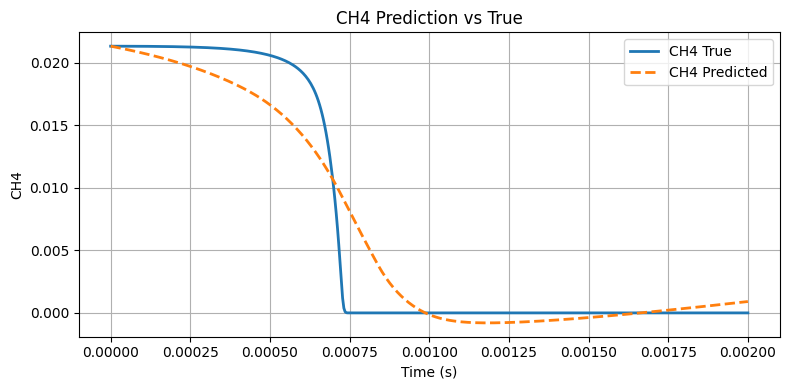

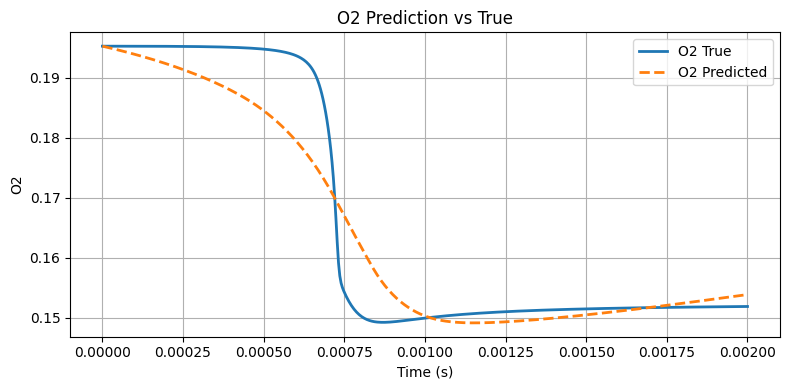

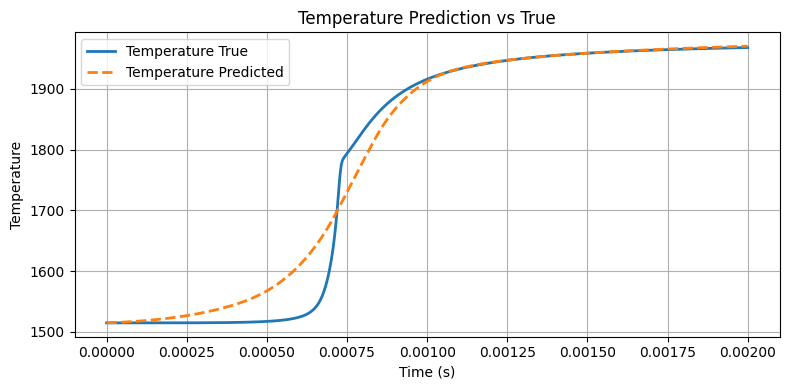

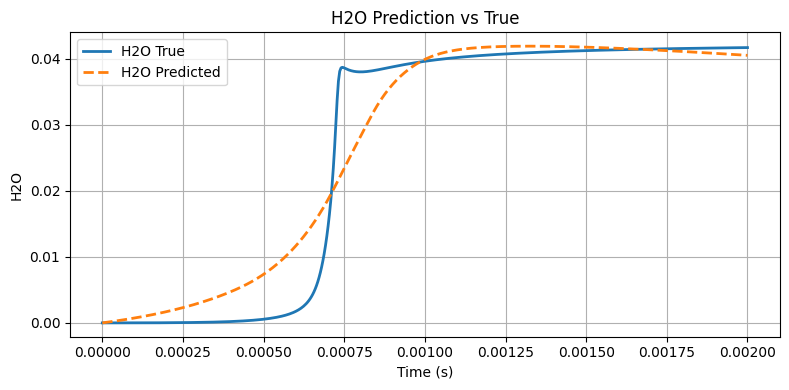

In [ ]:
import matplotlib.pyplot as plt

species_cols = {'CH4': 'CH4', 'O2': 'O2', 'Temperature': 'temperature', 'H2O' : 'H2O'}

for name, col in species_cols.items():
    idx = df.columns.drop('time').get_loc(col)  # get correct index in Y/pred
    y_true = df[col].values                      # Original values from CSV
    y_pred = Y_pred[:, idx].cpu().numpy()          # Predicted (denormalized)

    plt.figure(figsize=(8, 4))
    plt.plot(t.numpy(), y_true, label=f'{name} True', linewidth=2)
    plt.plot(t.numpy(), y_pred, '--', label=f'{name} Predicted', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel(name)
    plt.title(f'{name} Prediction vs True')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Testing on the testing datset

In [ ]:
df_test = pd.read_csv('/content/testing_filtered_3.csv')



In [ ]:
df_test

,time,O2,H2O,CO2,CH4,N2O,HCNN,temperature
0,0.000000,0.195795,0.000000e+00,0.000000,0.019935,0.000000e+00,0.000000,1515.000000
1,0.000004,0.195795,1.749138e-08,0.000000,0.019935,0.000000e+00,0.000000,1514.999134
2,0.000008,0.195795,6.173571e-08,0.000000,0.019935,0.000000e+00,0.000000,1514.998303
3,0.000012,0.195795,1.178025e-07,0.000000,0.019935,0.000000e+00,0.000000,1514.997496
4,0.000016,0.195795,1.864501e-07,0.000000,0.019934,0.000000e+00,0.000000,1514.996713
...,...,...,...,...,...,...,...,...
496,0.001984,0.155222,3.894649e-02,0.019743,0.000000,7.967005e-07,0.000012,1939.253633
497,0.001988,0.155224,3.894866e-02,0.019744,0.000000,7.953967e-07,0.000012,1939.295026
498,0.001992,0.155226,3.895081e-02,0.019745,0.000000,7.940768e-07,0.000012,1939.336120
499,0.001996,0.155228,3.895296e-02,0.019746,0.000000,7.927726e-07,0.000012,1939.376917


In [ ]:
t_test = torch.tensor(df_test['time'].values, dtype=torch.float32)  # shape [T]
Y_test = torch.tensor(df_test.drop(columns=['time']).values, dtype=torch.float32)
Y_test_norm = (Y_test - mean) / std

In [ ]:
Y_test.shape

torch.Size([501, 7])

In [ ]:
Y_test

tensor([[1.9580e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        [1.9580e-01, 1.7491e-08, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        [1.9580e-01, 6.1736e-08, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5150e+03],
        ...,
        [1.5523e-01, 3.8951e-02, 1.9745e-02,  ..., 7.9408e-07, 1.2383e-05,
         1.9393e+03],
        [1.5523e-01, 3.8953e-02, 1.9746e-02,  ..., 7.9277e-07, 1.2393e-05,
         1.9394e+03],
        [1.5523e-01, 3.8955e-02, 1.9747e-02,  ..., 7.9145e-07, 1.2403e-05,
         1.9394e+03]])

In [ ]:
pred_norm = odeint(ode_func, Y_test_norm[0], t_test)

predictions = pred_norm * std + mean

In [ ]:
predictions.shape

torch.Size([501, 7])

In [ ]:
component_names = ['O2','H2O', 'CO2', 'CH4', 'N2O', 'HCNN', 'temperature']

print(f"{'Component':<12} {'MSE':>10} {'MAE':>10} {'R2 Score':>10}")
print("-" * 42)

for i, name in enumerate(component_names):
    y_true = Y_test[:, i]
    y_pred = predictions[:, i]

    mse = torch.mean((y_true - y_pred) ** 2).item()
    mae = torch.mean(torch.abs(y_true - y_pred)).item()

    # R2 Score: 1 - SSR/SST
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)  # epsilon added to avoid division by zero
    r2 = r2.item()

    print(f"{name:<12} {mse:10.6f} {mae:10.6f} {r2:10.4f}")

Component           MSE        MAE   R2 Score
------------------------------------------
O2             0.000023   0.003613     0.9371
H2O            0.000020   0.003366     0.9368
CO2            0.000003   0.001239     0.9595
CH4            0.000005   0.001650     0.9438
N2O            0.000000   0.000000     0.9969
HCNN           0.000000   0.000002     0.9111
temperature  771.453735  24.897957     0.9780


In [ ]:
temp_idx = df_test.columns.get_loc('temperature') - 1

t_np = t_test.numpy()
T_pred = predictions[:, temp_idx].cpu().detach().numpy()
T_true = Y_test[:, temp_idx].numpy()

#Compute dT/dt
dTdt_pred = np.gradient(T_pred, t_np)
dTdt_true = np.gradient(T_true, t_np)

#find index of maximum gradient
i_pred = np.argmax(dTdt_pred)
i_true = np.argmax(dTdt_true)

# Extract the delay times
t_ign_pred = t_np[i_pred]
t_ign_true = t_np[i_true]

print(f"Ignition delay (true): {t_ign_true:.6e} s")
print(f"Ignition delay (pred): {t_ign_pred:.6e} s")
print(f"Error (µs): {(t_ign_pred - t_ign_true)*1e6:.2f} µs")

Ignition delay (true): 7.160000e-04 s
Ignition delay (pred): 7.400000e-04 s
Error (µs): 24.00 µs


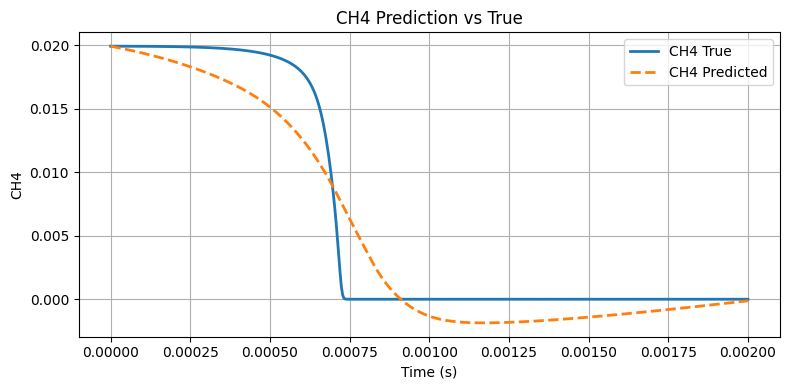

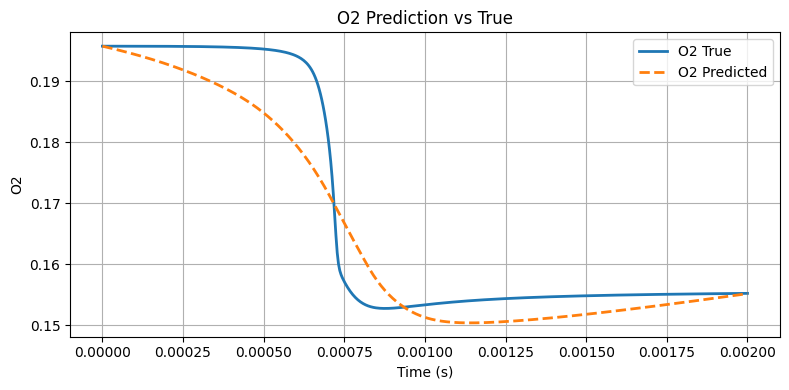

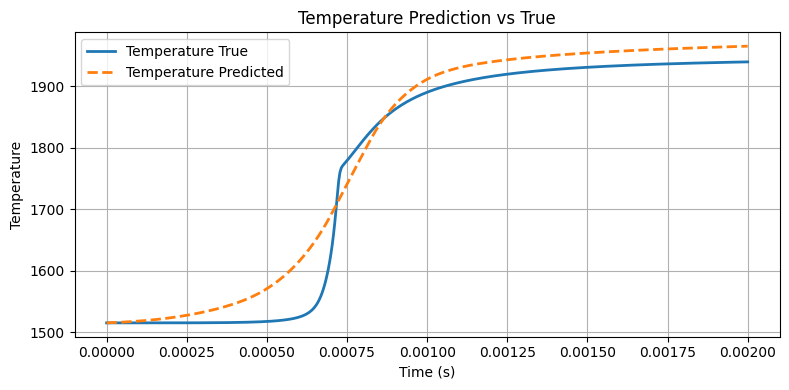

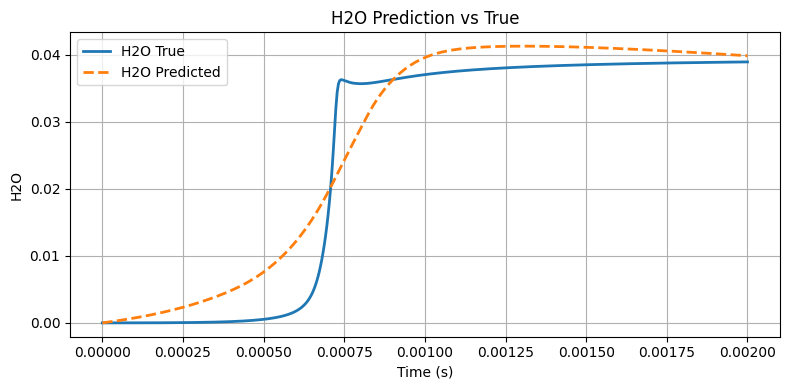

In [ ]:
import matplotlib.pyplot as plt

# Use correct column names from your DataFrame
species_cols = {'CH4': 'CH4', 'O2': 'O2', 'Temperature': 'temperature', 'H2O' : 'H2O'}

for name, col in species_cols.items():
    idx = df_test.columns.drop('time').get_loc(col)  # get correct index in Y/pred
    y_true = df_test[col].values                      # Original values from CSV
    y_pred = predictions[:, idx].detach().cpu().numpy()          # Predicted (denormalized)

    plt.figure(figsize=(8, 4))
    plt.plot(t.numpy(), y_true, label=f'{name} True', linewidth=2)
    plt.plot(t.numpy(), y_pred, '--', label=f'{name} Predicted', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel(name)
    plt.title(f'{name} Prediction vs True')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()